Hurst exponent , kauffman efficiency and ADF test

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
from curl_cffi import requests

session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('AMT', session=session)
risk_free = yf.Ticker('^GSPC', session=session)

# Set time horizon using the `period` or `start`/`end` arguments
amt_data = ticker.history(period="1y")  # Last 1 year
sp500_data = risk_free.history(start="2023-01-01", end="2024-01-01")  # Custom range
return_df= amt_data[['Close']].reset_index()
return_df.columns = ['Date', 'Close']
riskfree_df = sp500_data[['Close']].reset_index()
riskfree_df.columns = ['Date', 'Close']

return_df['Date'] = pd.to_datetime(return_df['Date'])
return_df['Date'] = return_df['Date'].dt.strftime('%Y-%m-%d')
return_df.head()
riskfree_df['Date'] = pd.to_datetime(riskfree_df['Date'])
riskfree_df['Date'] = riskfree_df['Date'].dt.strftime('%Y-%m-%d')

return_df.head()
riskfree_df.head()

,Date,Close
0,2023-01-03,3824.139893
1,2023-01-04,3852.969971
2,2023-01-05,3808.100098
3,2023-01-06,3895.080078
4,2023-01-09,3892.090088


In [8]:
returns = return_df['Close'].pct_change().dropna()
return_df['Log_Return'] = np.log(return_df['Close'] / return_df['Close'].shift(1))
return_df = return_df.dropna(subset=['Log_Return'])

def kaufman_ratio(prices, window = 100):
    signal = prices.diff(window).abs()
    noise = prices.diff().abs().rolling(window).sum()

    er = signal / noise
    return er

return_df['kaufman'] = kaufman_ratio(return_df['Close'], window=100)
return_df = return_df.dropna(subset=['kaufman'])
return_df['kaufman'].head()

104    0.127501
105    0.115388
106    0.134005
107    0.134372
108    0.176573
Name: kaufman, dtype: float64

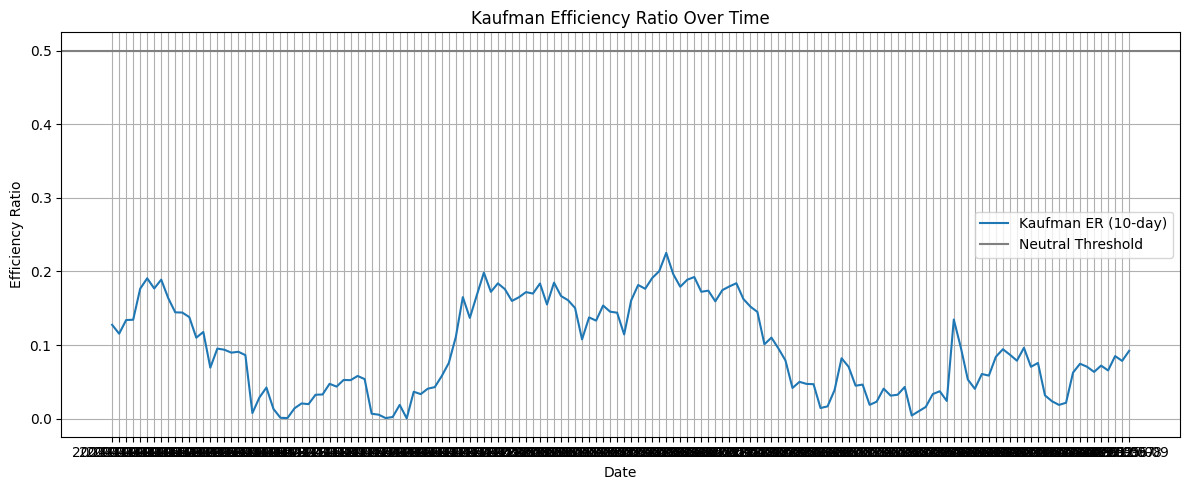

In [9]:
plt.figure(figsize=(12,5))
plt.plot(return_df['Date'], return_df['kaufman'], label='Kaufman ER (10-day)')
plt.axhline(0.5, color='gray', label='Neutral Threshold')
plt.title('Kaufman Efficiency Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Efficiency Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
series = return_df['Log_Return'].dropna() #initialise series
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(series)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

#hurst exponent calculation , used lag values

def hurst_exponent(ts, max_lag= 150):
    lags = range(2,max_lag)
    
    tau =[np.std(np.subtract(ts[:lags], ts[:-lags])) for lag in lags] #calculating varinace Xt - Xt-1
    
    poly = polyfit(log(lags), lag(tau), 1)
    return poly[0]*2.0 #log^2H

ADF Statistic: -12.529532249407032
p-value: 2.4460000806736487e-23
Critical Values: {'1%': -3.476273058920005, '5%': -2.881687616548444, '10%': -2.5775132580261593}


In [ ]:
import numpy as np
def hurst_exponent(ts, max_lag= 150):
    lags = range(2,max_lag)
    
    tau =[np.std(np.subtract(ts[:lags], ts[:-lags])) for lag in lags] #calculating varinace Xt - Xt-1
    
    poly = polyfit(log(lags), lag(tau), 1)
    return poly[0]*2.0 #log^2H

hurst = hurst_exponent(return_df['Close'].dropna().values())
print("Hurst Exponent:", hurst)